---
title: 3 Layer Stacked QG Model
subject: Jax Approximate Ocean Models
# subtitle: How can I estimate the state AND the parameters?
short_title: Stacked QG
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CNRS
      - MEOM
    orcid: 0000-0002-6739-0053
    email: jemanjohnson34@gmail.com
  - name: Takaya Uchida
    affiliations:
      - FSU
    orcid: https://orcid.org/0000-0002-8654-6009
    email: takachanbo@gmail.com
license: CC-BY-4.0
keywords: jax, shallow water model, differentiable
abbreviations:
    SW: Shallow Water
    QG: Quasi-Geostrophic
    PDE: Partial Differential Equation
    RHS: Right Hand Side
---

In [1]:
import autoroot
import typing as tp
import equinox as eqx 
from fieldx._src.domain.domain import Domain
import einops

import math
import diffrax as dfx
from jaxtyping import Array, Float
import jax
import numpy as np
import jax.numpy as jnp
import jax.scipy as jsp
from jax.config import config
import pandas as pd
from finitevolx import laplacian, divergence, geostrophic_gradient, x_avg_2D, y_avg_2D, center_avg_2D, MaskGrid, reconstruct
from somax._src.operators.dst import (
    helmholtz_dst, laplacian_dst, inverse_elliptic_dst, inverse_elliptic_dst_cmm, compute_capacitance_matrices
)
from somax._src.models.qg.params import QGParams
from somax._src.models.qg.domain import LayerDomain
from somax._src.models.qg.elliptical import DSTSolution, calculate_helmholtz_dst, compute_homogeneous_solution

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
config.update("jax_enable_x64", True)


%matplotlib inline
%load_ext autoreload
%autoreload 2

/tmp/ipykernel_3134671/1701600949.py:14: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


#### Plot Utils

In [2]:
from loguru import logger


def plot_field(field, name=""):
    num_axis = len(field)
    fig, ax = plt.subplots(ncols=num_axis, figsize=(8, 2))
    vmin, vmax = np.min(field), np.max(field)
    fig.suptitle(name)
    for i in range(num_axis):
        pts = ax[i].pcolormesh(field[i].T, cmap="coolwarm", vmin=vmin, vmax=vmax)
        plt.colorbar(pts)

    plt.tight_layout()
    plt.show()


def print_debug_quantity(quantity, name=""):
    size = quantity.shape
    min_ = jnp.min(quantity)
    max_ = jnp.max(quantity)
    mean_ = jnp.mean(quantity)
    median_ = jnp.mean(quantity)
    jax.debug.print(
        f"{name}: {size} | {min_:.6e} | {mean_:.6e} | {median_:.6e} | {max_:.6e}"
    )

In [3]:
# # Low Resolution (Non-Resolving)
# Nx, Ny = 64, 64
# Low Resolution (Non-Resolving)
# Nx, Ny = 128, 128
# Low Resolution
# Nx, Ny = 256, 256
# High Resolution
# Nx, Ny = 512, 512
# Nx, Ny = 769, 961
Nx, Ny = 1024, 1024

# Lx, Ly = 3840.0e3, 4800.0e3
Lx, Ly = 5_120.0e3, 5_120.0e3

dx, dy = Lx / Nx, Ly / Ny

xy_domain = Domain(
    xmin=(0.0,0.0), 
    xmax=(Lx,Ly),
    Lx=(Lx,Ly),
    Nx=(Nx, Ny), 
    dx=(dx, dy)
)

params = QGParams(y0=0.5 * Ly)

In [4]:
xy_domain

Domain(
  xmin=(0.0, 0.0),
  xmax=(5120000.0, 5120000.0),
  dx=(5000.0, 5000.0),
  Nx=(1024, 1024),
  Lx=(5120000.0, 5120000.0),
  ndim=2
)

In [30]:
xy_domain.dx

(5000.0, 5000.0)

In [5]:
# # octogonal domain
# domain_type = "octogonal"
# mask = np.ones((Nx-1,Ny-1))
# for i in range(Nx//4):
#     for j in range(Ny//4):
#         if i+j < min(Nx//4, Ny//4):
#             mask[i,j] = 0.
#             mask[i,-1-j] = 0.
#             mask[-1-i,j] = 0.
#             mask[-1-i,-1-j] = 0.
            
# masks = MaskGrid.init_mask(mask, location="center")

domain_type = "rectangular"

mask = jnp.ones((Nx,Ny))
mask = mask.at[0].set(0.0)
mask = mask.at[-1].set(0.0)
mask = mask.at[:,0].set(0.0)
mask = mask.at[:,-1].set(0.0)
masks = MaskGrid.init_mask(mask, location="node")


In [6]:
# psi0 = np.load("/Users/eman/code_projects/data/qg_runs/psi_000y_090d.npy")
# psi0.shape

### Layer domain

In [7]:
# heights
# heights = [350.0, 750.0, 2900.0]
heights = [400.0, 1_100.0, 2_600.0]

# reduced gravities
reduced_gravities = [0.025, 0.0125]

# initialize layer domain
with jax.default_device(jax.devices("cpu")[0]):
    layer_domain = LayerDomain(heights, reduced_gravities, correction=False)

### Helmoltz

In [8]:
H_mat = calculate_helmholtz_dst(xy_domain, layer_domain, params)

H_mat.shape

(3, 254, 254)

### Homogeneous Solution

In [10]:
psi0 = jnp.ones(shape=(layer_domain.Nz,) + xy_domain.Nx)

# psi0 = np.load("/Users/eman/code_projects/data/qg_runs/psi_000y_360d.npy")[0]
lambda_sq = params.f0**2 *einops.rearrange(layer_domain.lambda_sq, "Nz -> Nz 1 1")

homsol = compute_homogeneous_solution(
        psi0, 
        lambda_sq=lambda_sq,
        H_mat=H_mat
    )
print_debug_quantity(homsol, "HOMSOL")

# calculate homogeneous solution
homsol_i = jax.vmap(center_avg_2D)(homsol) * masks.center.values

homsol_mean = einops.reduce(homsol_i, "Nz Nx Ny -> Nz 1 1", reduction="mean")
print_debug_quantity(homsol_mean, "HOMSOL MEAN")

# CALCULATE CAPCITANCE MATRIX
if domain_type == "octogonal":
        cap_matrices = compute_capacitance_matrices(
            H_mat, 
            masks.node.irrbound_xids,
            masks.node.irrbound_yids
        )
else:
    cap_matrices = None
    
# DST SOLUTION
dst_sol = DSTSolution(
        homsol=homsol, 
        homsol_mean=homsol_mean, 
        H_mat=H_mat,
        capacitance_matrix=cap_matrices
    )

HOMSOL: (3, 256, 256) | -2.220446e-15 | 3.565769e-01 | 3.565769e-01 | 1.000000e+00
HOMSOL MEAN: (3, 1, 1) | 2.140031e-02 | 3.515206e-01 | 3.515206e-01 | 1.000000e+00


### Custom Forcing

In [7]:
from somax._src.models.qg.forcing import calculate_bottom_drag, calculate_wind_forcing

In [8]:
wind_forcing = calculate_wind_forcing(
    domain=xy_domain,
    H_0=layer_domain.heights[0],
    tau0=0.08/1_000.0,
)


def forcing_fn(
    psi: Float[Array, "Nz Nx Ny"],
    dq: Float[Array, "Nz Nx-1 Ny-1"],
    domain: Domain,
    layer_domain: LayerDomain,
    params: QGParams,
    masks: MaskGrid,
) -> Float[Array, "Nz Nx Ny"]:
    
    # add wind forcing
    dq = dq.at[0].add(wind_forcing)
    
    # calculate bottom drag
    bottom_drag = calculate_bottom_drag(
        psi=psi, domain=domain,
        H_z=layer_domain.heights[-1],
        delta_ek=params.delta_ek,
        f0=params.f0,
        masks_psi=masks.node
    )
    

    dq = dq.at[-1].add(bottom_drag)
    
    return dq
    
    

### Initial Quantities

In [9]:

from somax._src.models.qg.operators import (
    calculate_potential_vorticity,
    calculate_psi_from_pv,
    equation_of_motion
)

In [10]:
# PV
q0 = calculate_potential_vorticity(
    psi0, xy_domain, layer_domain, 
    params=params,
    masks_psi=masks.node, 
    masks_q=masks.center
)

In [11]:
dq = equation_of_motion(
    q=q0, psi=psi0, params=params,
    domain=xy_domain, layer_domain=layer_domain,
    forcing_fn=forcing_fn,
    masks=masks
)

dpsi = calculate_psi_from_pv(
    q=dq,
    layer_domain=layer_domain,
    mask_node=masks.node,
    dst_sol=dst_sol
)

## Equation of Motion

In [12]:
class State(eqx.Module):
    q: Array
    psi: Array

In [13]:
def vector_field(t: float, state: State, args) -> State:
    
    dq = equation_of_motion(
        q=state.q, psi=state.psi, params=params,
        domain=xy_domain, layer_domain=layer_domain,
        forcing_fn=forcing_fn,
        masks=masks
    )

    dpsi = calculate_psi_from_pv(
        q=dq,
        layer_domain=layer_domain,
        mask_node=masks.node,
        dst_sol=dst_sol
    )
    
    state = eqx.tree_at(lambda x: x.q, state, dq)
    state = eqx.tree_at(lambda x: x.psi, state, dpsi)
    
    return state

## Time Stepping

About 1 year

In [14]:
dt = 1_000

tmin = 0.0
num_years = 1
num_days = 360
tmax = pd.to_timedelta(num_years * num_days, unit="days").total_seconds()
num_save = 20

In [15]:
from fieldx._src.domain.time import TimeDomain

t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

In [16]:
# Euler, Constant StepSize
# solver = dfx.Tsit5()
# solver = dfx.Heun()
solver = dfx.Bosh3()

# Tolerances
stepsize_controller = dfx.PIDController(rtol=1e-5, atol=1e-5)
# stepsize_controller = dfx.ConstantStepSize()

In [17]:
psi0 *= 0.
# psi0 = np.load("/Users/eman/code_projects/data/qg_runs/psi_0.986y_360.00d_octogonal.npy")

q0 = calculate_potential_vorticity(
    psi0, xy_domain, layer_domain, 
    params=params,
    masks_psi=masks.node, 
    masks_q=masks.center
)

state_init = State(q=q0, psi=psi0)

In [18]:
%%time
# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(vector_field),
    solver=solver,
    t0=tmin,
    t1=tmax,
    dt0=dt,
    y0=state_init,
    saveat=saveat,
    args=None,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

CPU times: user 1min 23s, sys: 875 ms, total: 1min 23s
Wall time: 1min 21s


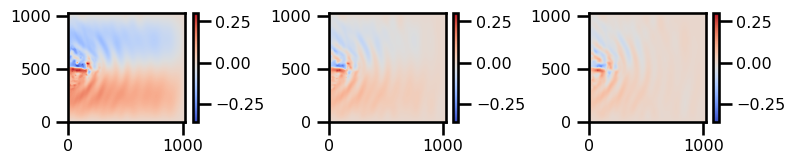

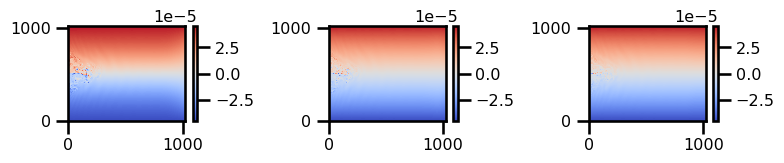

In [19]:
plot_field(sol.ys.psi[-1]/ (9.81 / params.f0))
plot_field(sol.ys.q[-1])

### Re-Run Simulation

1+1 years

In [20]:
%%time
# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(vector_field),
    solver=solver,
    t0=tmin,
    t1=tmax,
    dt0=dt,
    y0=State(sol.ys.q[-1], sol.ys.psi[-1]),
    saveat=saveat,
    args=None,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

CPU times: user 2min 2s, sys: 724 ms, total: 2min 3s
Wall time: 2min


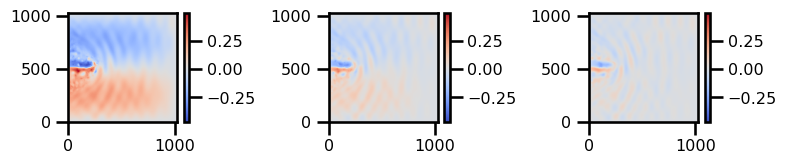

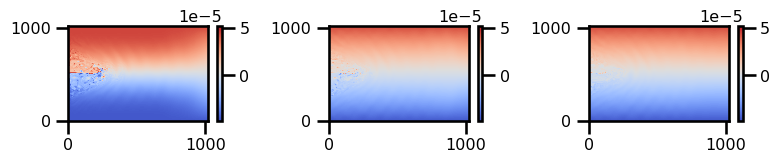

In [21]:
plot_field(sol.ys.psi[-1]/ (9.81 / params.f0))
plot_field(sol.ys.q[-1])

### Run Simulation Longer

1+1+10 years

In [22]:
dt = 9_00

tmin = 0.0
num_days = 360*10 # 360 # # 10 # 180 # 30 # 60 #
tmax = pd.to_timedelta(num_days, unit="days").total_seconds()
num_save = 20

t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

In [23]:
%%time
# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(vector_field),
    solver=solver,
    t0=tmin,
    t1=tmax,
    dt0=dt,
    y0=State(sol.ys.q[-1], sol.ys.psi[-1]),
    saveat=saveat,
    args=None,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

CPU times: user 44min 28s, sys: 3.54 s, total: 44min 31s
Wall time: 44min 34s


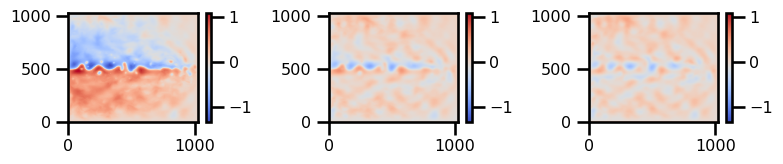

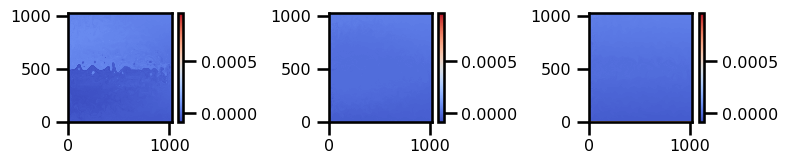

In [24]:
plot_field(sol.ys.psi[-1]/ (9.81 / params.f0))
plot_field(sol.ys.q[-1])

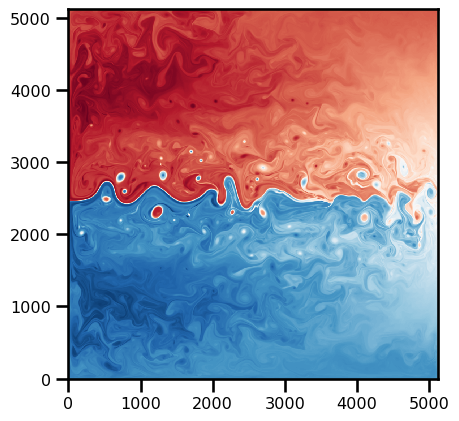

In [28]:
fig, ax = plt.subplots()
ax.pcolormesh(np.linspace(0,Lx,Nx)*1e-3, np.linspace(0,Ly,Ny)*1e-3, sol.ys.q[-1,0].T,
              cmap='RdBu_r'
             )
ax.set_aspect('equal')

In [35]:
sol

Solution(
  t0=f64[],
  t1=f64[],
  ts=f64[20],
  ys=State(q=f64[20,3,1023,1023], psi=f64[20,3,1024,1024]),
  interpolation=None,
  stats={
    'max_steps':
    None,
    'num_accepted_steps':
    i64[],
    'num_rejected_steps':
    i64[],
    'num_steps':
    i64[]
  },
  result=i64[],
  solver_state=None,
  controller_state=None,
  made_jump=None
)

In [37]:
Z = np.array([200., heights[0]+.5*heights[1], heights[1]+.5*heights[2]])
import xarray as xr
dsave = xr.DataArray(sol.ys.q, dims=['time','Z','XC','YC'],
                     coords={'time':ts,'Z':Z,
                             'XC':np.arange(xy_domain.dx[0]*.5, xy_domain.Lx[0]-xy_domain.dx[0]*.5, xy_domain.dx[0]),
                             'YC':np.arange(xy_domain.dx[1]*.5, xy_domain.Lx[1]-xy_domain.dx[1]*.5, xy_domain.dx[1])}
                    ).to_dataset(name='q')
dsave['psi'] = xr.DataArray(sol.ys.psi, dims=['time','Z','Xp1','Yp1'],
                     coords={'time':ts,'Z':Z,
                             'Xp1':np.arange(0, xy_domain.Lx[0], xy_domain.dx[0]),
                             'Yp1':np.arange(0, xy_domain.Lx[1], xy_domain.dx[1])}
                    )
dsave

<xarray.Dataset>
Dimensions:  (time: 20, Z: 3, XC: 1023, YC: 1023, Xp1: 1024, Yp1: 1024)
Coordinates:
  * time     (time) float64 0.0 1.637e+07 3.274e+07 ... 2.947e+08 3.11e+08
  * Z        (Z) float64 200.0 950.0 2.4e+03
  * XC       (XC) float64 2.5e+03 7.5e+03 1.25e+04 ... 5.108e+06 5.112e+06
  * YC       (YC) float64 2.5e+03 7.5e+03 1.25e+04 ... 5.108e+06 5.112e+06
  * Xp1      (Xp1) float64 0.0 5e+03 1e+04 ... 5.105e+06 5.11e+06 5.115e+06
  * Yp1      (Yp1) float64 0.0 5e+03 1e+04 ... 5.105e+06 5.11e+06 5.115e+06
Data variables:
    q        (time, Z, XC, YC) float64 -4.489e-05 -4.489e-05 ... 0.0008776
    psi      (time, Z, Xp1, Yp1) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [41]:
import os.path as op
savedir = '/nexsan/people/tuchida/'
dsave.chunk({'time':1,'Z':1}).to_zarr(op.join(savedir,'somax/double-gyre/RUNS/spinup/rectangular/1024.zarr'), mode='w')